In [60]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Loading Data

In [61]:
df=pd.read_csv('Binance_ETHUSDT_d - Binance_ETHUSDT_d.csv')

In [62]:
df.head()

,date,open,high,low,close
0,2021-05-18 0:00:00,3282.25,3304.82,3240.00,3260.97
1,2021-05-17 0:00:00,3581.81,3587.06,3102.00,3282.51
2,2021-05-16 0:00:00,3646.24,3879.00,3343.06,3582.10
3,2021-05-15 0:00:00,4075.02,4134.05,3632.00,3646.68
4,2021-05-14 0:00:00,3717.92,4173.28,3691.35,4075.01


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1372 non-null   object 
 1   open    1372 non-null   float64
 2   high    1372 non-null   float64
 3   low     1372 non-null   float64
 4   close   1372 non-null   float64
dtypes: float64(4), object(1)
memory usage: 53.7+ KB


In [64]:
from datetime import date
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline
sns.set_style('darkgrid')
import plotly.graph_objects as go

## Visualisation of Ethereum Prices using its trading features

In [65]:
fig = go.Figure(data=go.Ohlc(x=df['date'],
                    open=df['open'],
                    high=df['high'],
                    low=df['low'],
                    close=df['close']))
fig.show()

In [66]:
import plotly.express as px
fig = px.line(df, x='date', y='close')
fig.show()

## Min-Max Scaling data 

In [67]:
close_data=df.reset_index()['close']

In [68]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaled_data=scaler.fit_transform(np.array(close_data).reshape(-1,1))

## Train/Test Splitting Data

In [69]:
train_size=int(len(scaled_data)*0.7)
test_size=len(scaled_data)-train_size
train_data,test_data=scaled_data[0:train_size,:],scaled_data[train_size:len(scaled_data),:]

In [70]:
train_size,test_size

(960, 412)

In [71]:
def time_series_data(dataset,step):
    x,y=[],[]
    for i in range(len(dataset)-step-1):
        # creating a series of values
        series=dataset[i:(i+step),0]
        # appending that series to x
        x.append(series)
        # appending the next values of series x after step to y
        y.append(dataset[i+step,0])
    return np.array(x),np.array(y)

In [72]:
step=9
x_train,y_train=time_series_data(train_data,step)
x_test,y_test=time_series_data(test_data,step)

In [73]:
x_train.shape,y_train.shape

((950, 9), (950,))

In [74]:
x_train =x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 1)

## Model Building

In [75]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(49,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='mean_squared_error',optimizer='adam')

In [76]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 49, 50)            10400     
                                                                 
 lstm_10 (LSTM)              (None, 49, 50)            20200     
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [77]:
history=model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=50,batch_size=64)

Epoch 1/50


ValueError: in user code:

    File "C:\Users\swank\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\swank\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\swank\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\swank\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\swank\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\swank\anaconda3\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 49, 1), found shape=(None, 9, 1)


## Plotting losses

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(15,4))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## Making Predictions

In [78]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

ValueError: in user code:

    File "C:\Users\swank\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\swank\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\swank\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\swank\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "C:\Users\swank\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\swank\anaconda3\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 49, 1), found shape=(None, 9, 1)


In [79]:
# doing inverse transform to scale it back to original scale
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

NameError: name 'train_predict' is not defined

In [80]:
y_test=scaler.inverse_transform(y_test.reshape(y_test.shape[0],1))

## Evaluation

In [81]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test,test_predict))

NameError: name 'test_predict' is not defined

NameError: name 'test_predict' is not defined

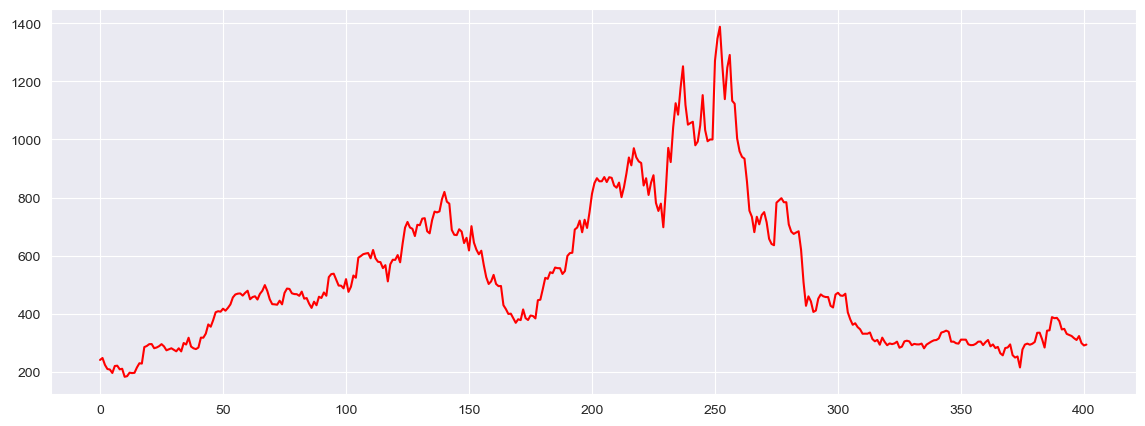

In [82]:
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real Ethereum Price')
plt.plot(test_predict, color = 'green', label = 'Predicted Ethereum Price')
plt.title('Ethereum Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

### Foreacsting for next 30 days